In [3]:
from pathlib import Path
import torch
import numpy as np
import scipy.io
import torch.utils.data as td

In [27]:
def load_burgers_1d(n_train, n_test, batch_size):
    sub = 2**0 #subsampling rate
    h = 2**13 // sub #total grid size divided by the subsampling rate
    s = h
    dl = scipy.io.loadmat('burgers_data_R10.mat')
    x_data = dl.get('a')[:,::sub]
    y_data = dl.get('u')[:,::sub]

    x_train = x_data[:n_train,:]
    y_train = torch.Tensor(y_data[:n_train,:])
    x_test = x_data[-n_test:,:]
    y_test = torch.Tensor(y_data[-n_test:,:])
    x_train = torch.Tensor(np.reshape(x_train, (n_train,s,1)))
    x_test = torch.Tensor(np.reshape(x_test, (n_test,s,1)))

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


    return train_loader, test_loader

In [28]:
# loading data: following the paper: training = 1000 and testing = 200
train_loader, test_loader = load_burgers_1d(n_train=1000, n_test=200, batch_size=16)

### Training

In [29]:
from losses import relative_h1_loss, relative_l2_loss
from FNO import FNO

In [30]:
batch_size = 16
epochs = 50 # paper has 500
model = FNO(16, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

total_l2 = 0
total_h1 = 0
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        u = model(x)
        mse = torch.nn.functional.mse_loss(u.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = relative_l2_loss(u.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()

    train_mse /= len(train_loader)
    train_l2 /= 800


    print("epoch " + str(ep), "train_mse: "+ str(train_mse), "l2 train error: " + str(train_l2))


initializing Fourier Integral Operator
initializing Fourier Integral Operator
initializing Fourier Integral Operator
initializing Fourier Integral Operator
epoch 0 train_mse: 0.49057827640088303 l2 train error: 0.04438588624820113
epoch 1 train_mse: 0.008373566278596483 l2 train error: 0.014167053978890181
epoch 2 train_mse: 0.0037824441420121323 l2 train error: 0.009361825976520776
epoch 3 train_mse: 0.0028893594169944877 l2 train error: 0.008254547668620944
epoch 4 train_mse: 0.001932057138118479 l2 train error: 0.006826693275943398
epoch 5 train_mse: 0.0019255403423726204 l2 train error: 0.006664884919300676
epoch 6 train_mse: 0.002683183553421663 l2 train error: 0.007862610705196858
epoch 7 train_mse: 0.0017695764226595028 l2 train error: 0.0065875246422365304
epoch 8 train_mse: 0.0031743208657846684 l2 train error: 0.00828359202016145
epoch 9 train_mse: 0.0014155506339323307 l2 train error: 0.005928453635424376
epoch 10 train_mse: 0.001124341256125638 l2 train error: 0.00525594358

In [31]:
count = 0
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        test_h1 = 0
        u = model(x)
        test_l2 += relative_l2_loss(u.view(batch_size, -1), y.view(batch_size, -1)).item()
        test_h1 += relative_h1_loss(u.view(batch_size, -1), y.view(batch_size, -1)).item()
        count += + 1
print("h1: ", test_h1 / count)
print("l2: ", test_l2 / count)

h1:  0.21018206156217134
l2:  0.0041558642226916095


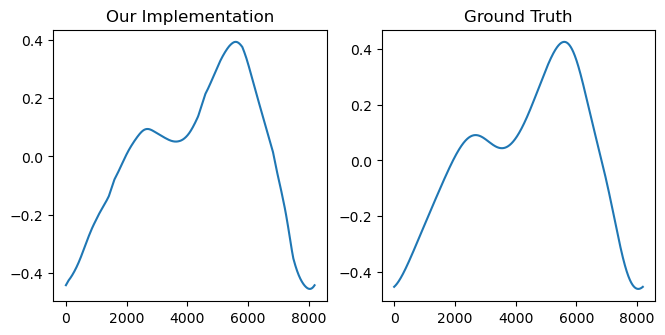

In [32]:
# %pip install matplotlib
# If possible, edit code below a bit?
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))

for x, y in test_loader:
    u = model(x)[10,:]
    y_print = y[10,:]
    #print(u[0,:].shape)

    ax = fig.add_subplot(3, 3, 1)
    # plt.plot(x[10])
    plt.plot(u.squeeze().detach().numpy())
    ax.set_title('Our Implementation')

    ax = fig.add_subplot(3, 3, 2)
    plt.plot(y_print.squeeze())
    ax.set_title('Ground Truth')

    break